In [232]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/students-performance-in-exams/StudentsPerformance.csv


In [233]:
train_df = pd.read_csv("../input/students-performance-in-exams/StudentsPerformance.csv")

In [234]:
print(len(train_df))
summary = pd.DataFrame(train_df.dtypes)
summary["Null"] = train_df.isnull().sum()
summary["first"] = train_df.loc[0]
summary["second"] = train_df.loc[1]
summary["third"] = train_df.loc[2]
summary["unique"] = train_df.nunique()
summary

1000


,0,Null,first,second,third,unique
gender,object,0,female,female,female,2
race/ethnicity,object,0,group B,group C,group B,5
parental level of education,object,0,bachelor's degree,some college,master's degree,6
lunch,object,0,standard,standard,standard,2
test preparation course,object,0,none,completed,none,2
math score,int64,0,72,69,90,81
reading score,int64,0,72,90,95,72
writing score,int64,0,74,88,93,77


We could see that there are feature which are object, like gender, race etc. We need to take care of them. Being object there are only few unique values and no null values. In total there are 1000 rows.

#### Feature Classification: Categorical and Numerical Features

In [235]:
cat_feats = train_df.select_dtypes("object").columns.to_list()
num_feats = [feats for feats in train_df.columns.to_list() if feats not in cat_feats]

#### Univariate Analysis of all features

In [236]:
def get_row_col_idx(idx):
    """Return the row index and  col index for plots"""
    row_idx = idx//2
    col_idx = idx%2
    return (row_idx, col_idx)

In [237]:
def write_percentage(train_df, ax):
    """Writes percentage on top of the bars on the plots"""
    for patches in ax.patches:
        height = patches.get_height()
        width = patches.get_width()
        x_loc = patches.get_x()
        values = height/len(train_df)*100
        ax.text(x = x_loc , y=height, s = '{:1.1f}%'.format(values), fontsize = 10 )

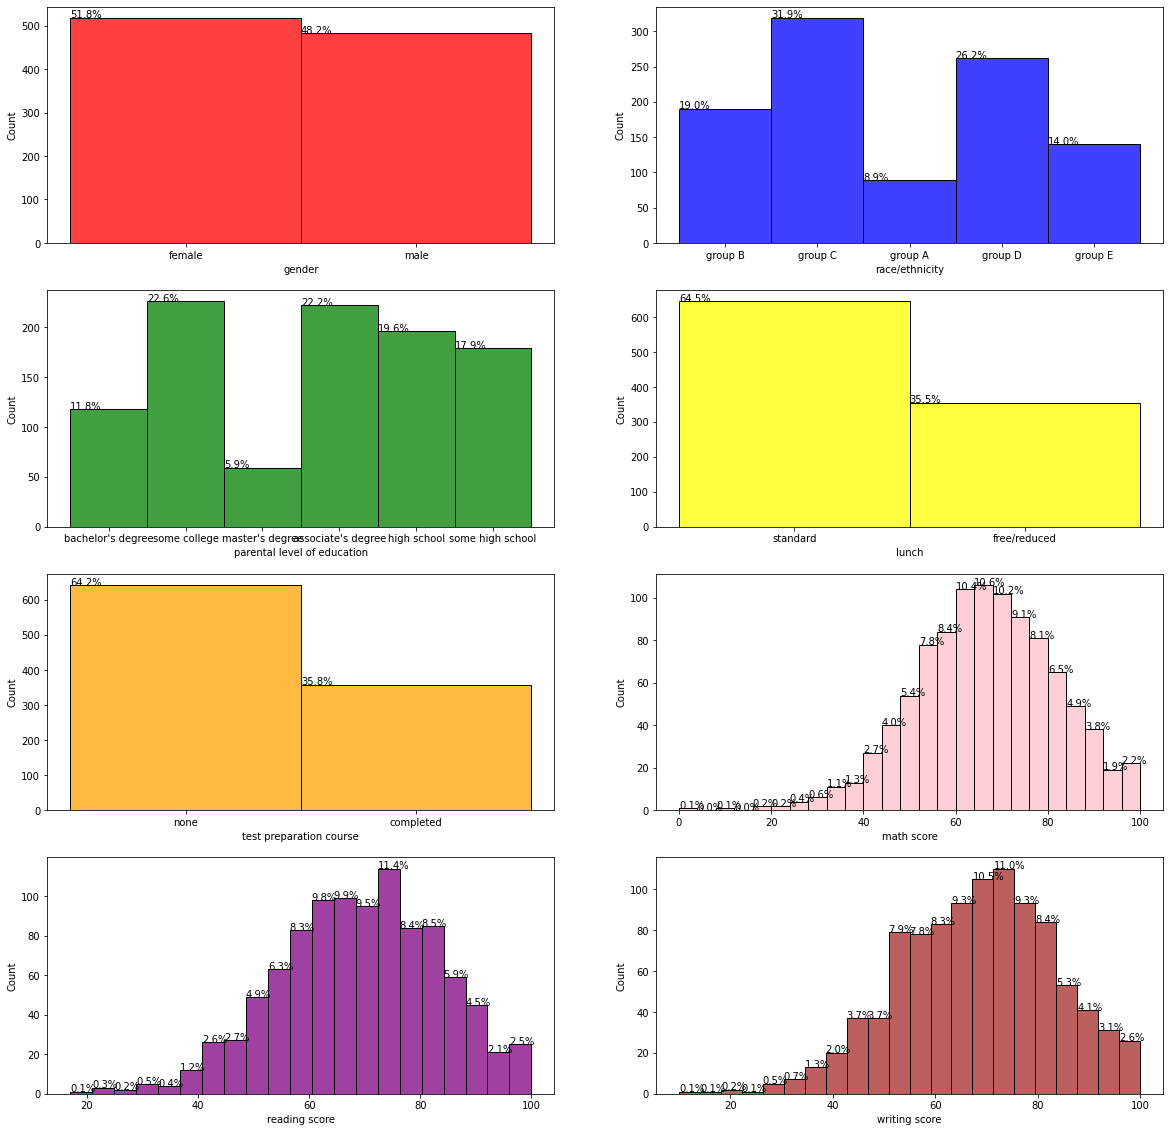

In [238]:
color = ["red", "blue", "green", "yellow", "orange", "pink", "purple", "brown"]
fig, ax = plt.subplots(4,2, figsize = (20,20))
for idx, cols in enumerate(train_df.columns.to_list()):
    row_idx, col_idx = get_row_col_idx(idx)
    col = color[idx]
    sns.histplot(x = cols, data = train_df, ax = ax[row_idx, col_idx], color = col )
    write_percentage(train_df, ax[row_idx, col_idx])

There are few obeservations which could be made from this chart:

1. We could see that there are more females in the dataset than the male gender. 
2. The percentage of group A people is least and of group C people is highest.
3. The population of people having parental education of master's degree is least in the dataset while people having parental education some degree and associate degree is max.
4. The count of people going for standard lunch is more that the free or reduced lunch.
5. People who finished their test prep course are less in number than the one's who did not finish.
6. People having math score of around 65-70 are more than the other ones.
7. People having reading score of around 70-75 are more than the other ones.
8. People having writing score of around 70-75 are more than the other ones.

In general we could say that the writing score, reading score and math score is normally distributed but they are skewed towards left.

#### KDE plot for numerical data

<AxesSubplot:ylabel='Density'>

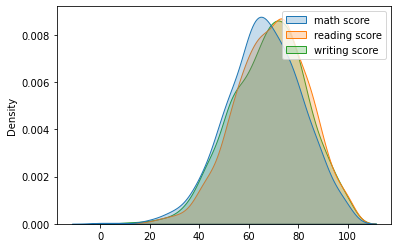

In [239]:
sns.kdeplot(data=train_df[num_feats],shade=True)


We can see the skewness in the plot. It is only skewed towards left. It is not highly skewed though.

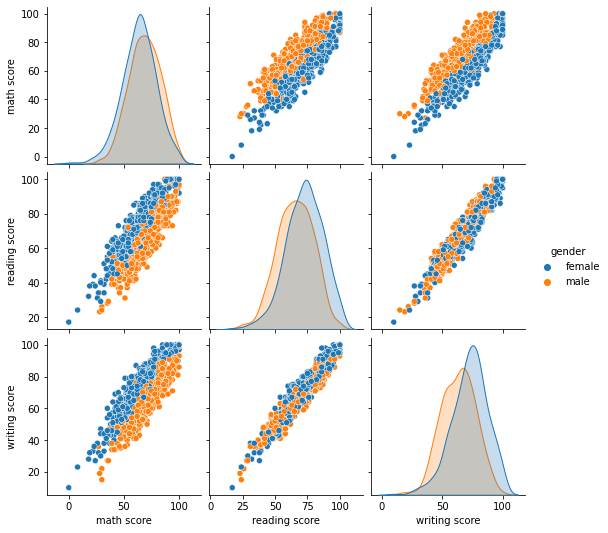

In [240]:
sns.pairplot(hue = "gender", data = train_df )

Following observation could be made from the above pair plot:
1. All the scores are increasing linearly with each other and they are increasing with the increase in other score.
2. In the plot between math score and other scores, we can also see that gender is seperating the dataset.
3. Most of the score lie betwee 50-100.

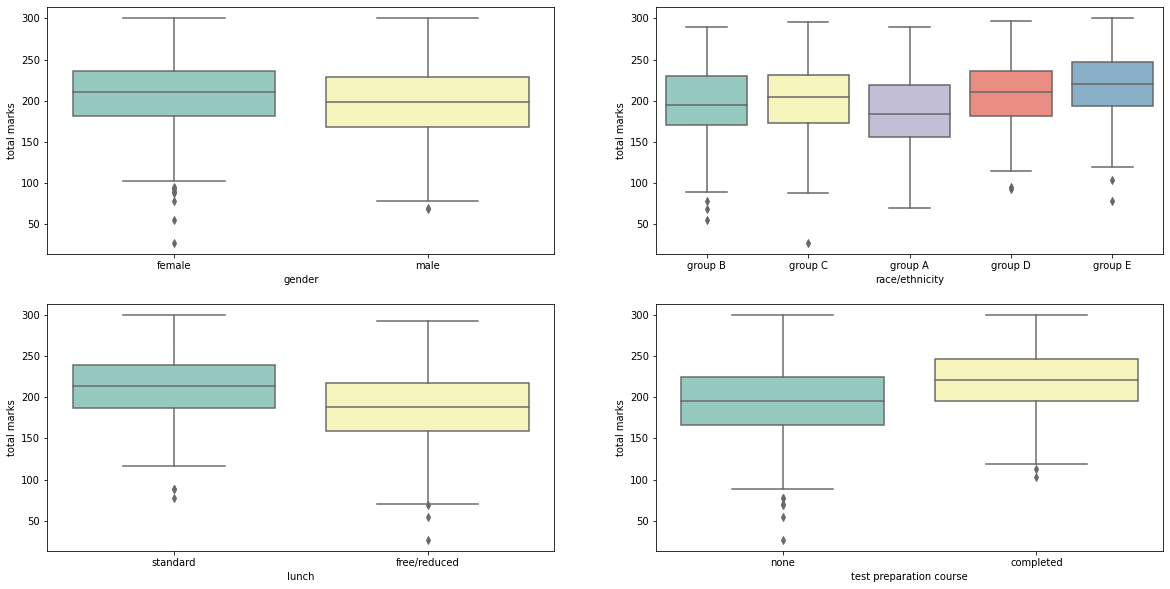

In [241]:
train_df["total marks"] = train_df["math score"] + train_df["reading score"] + train_df["writing score"]
fig, ax = plt.subplots(2,2,figsize = (20,10))
for idx,val in enumerate(["gender", "race/ethnicity", "lunch", 'test preparation course' ]):
    row_idx, col_idx = get_row_col_idx(idx)
    sns.boxplot(x = val, y = 'total marks',data = train_df, palette='Set3', ax=ax[row_idx, col_idx])

<AxesSubplot:xlabel='parental level of education', ylabel='total marks'>

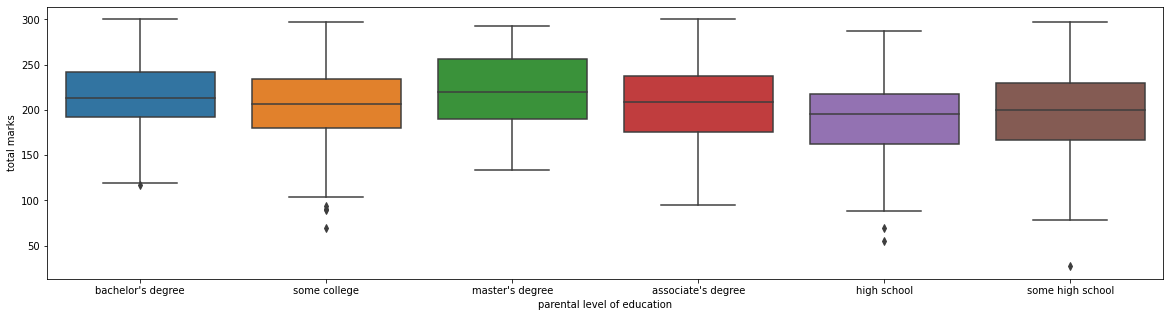

In [242]:
plt.figure(figsize=(20,5))
sns.boxplot(x = "parental level of education", y = "total marks", data = train_df)

From this above plot we could see that the people with their parental level of education having master's degree have performed better than others.Also, people with their parental level of education having high school degree have performed poorly. We could use label encoder to encode the categorical variables

### Model Training

In [243]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##### Getting Target

In [244]:
target = train_df.pop("total marks")
train_df = pd.get_dummies(train_df[cat_feats])

##### Data Splitting

In [245]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target, random_state = 0 )

In [246]:
target.shape
# X_test.shape

(1000,)

### Linear Model

In [247]:
lm = LinearRegression()
lm.fit(X_train, y_train)
mse = mean_squared_error(lm.predict(X_test), y_test)
r2 = r2_score(lm.predict(X_test), y_test)
print(mse,r2)

1455.017 -2.432052670726609


In [248]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
mse = mean_squared_error(dt.predict(X_test), y_test)
r2_score = r2_score(dt.predict(X_test), y_test)
print(mse, r2_score)

2060.899251542825 -0.9674061799415397
